This notebook was written for the course "Stochastic Finite Elements" of the Institute for Mechanics and Computational Mechanics at the Leibniz University Hannover in the summer term 2023. Its intention is to show the basic principle of Bayesian updating applied on a linear regression model. I do not guarantee that the implementation or the results are correct. Usage and distribution is permitted, use at your own discretion and risk.

Jan Grashorn, June 2023

In [1]:
import qrcode
img = qrcode.make('https://github.com/jgrashorn/BayesianExamples')
img.save('qrcode.png')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Since we want to do a linear regression, the model has two (unknown) parameters ($a$ and $b$) and consist of the function $y = ax + b$

To keep the notation, we define our random variable as $\theta = [a,b]^T$ such that the model is a function of both $x$ and $\theta$:

$M(\theta) = f(x,\theta)$

In [3]:
def model(x,theta):
    return theta[0]*x + theta[1] # theta[0] = a, theta[1] = b

Set initial parameters $a_0 = 2$ and $b_0 = 4$ and generate some data.

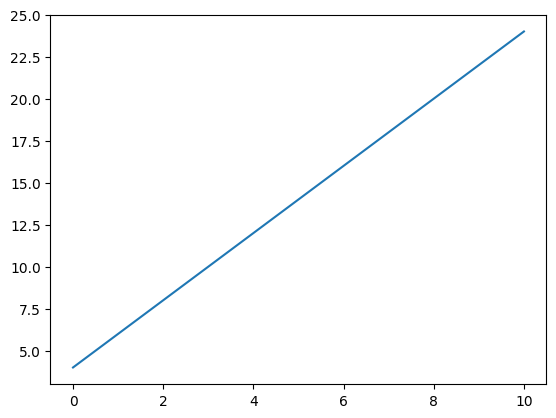

In [4]:
a0 = 2; b0 = 4; # nominal parameters
N = 5 # number of points

x = np.linspace(0,10,N)
y = model(x,[a0,b0])

plt.plot(x,y)

Great, that was easy! Now lets add some noise to the model to make it more interesting. We choose here additive noise $c \sim N(0,\sigma)$, such that the actual "measurement" becomes

$y_{meas}(x) = y(x) + c$

$y_{meas}(x) = ax + b + c$

We can then also plot the results for the original values $a_0$ and $b_0$. We choose here a noise level of $\sigma = 3$.

Text(0, 0.5, 'y')

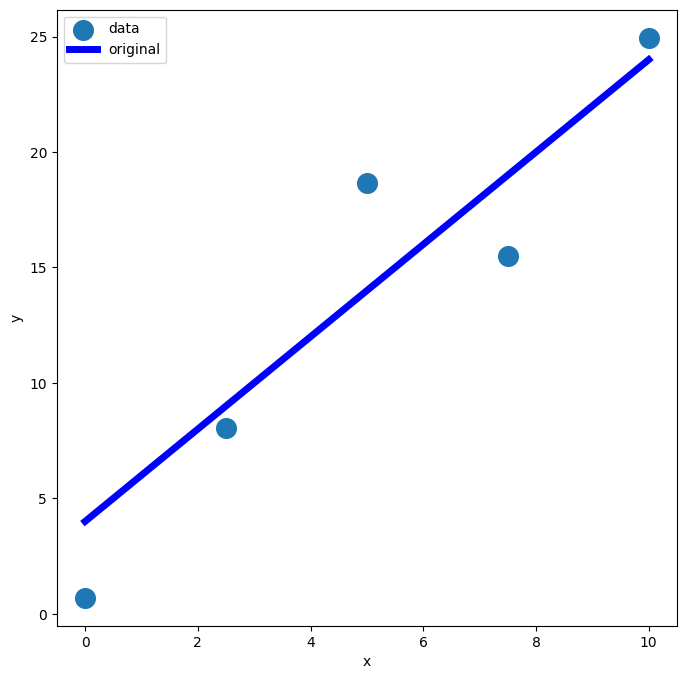

In [5]:
sigma = 3

yMeas = y + np.random.randn(N)*sigma

plt.figure(figsize=(8,8))
plt.scatter(x,yMeas,label='data',s=200)
plt.plot(x,y,'b-',label='original',lw=5)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

Remember that the objective of this excercise is to calculate (or infer) the actual values of $a$ and $b$ from the measurements of our model output $y$. To do this, we can use for example linear regression.$\\$
In order to do that, we need to define some sort of error between our model output based on our function input (the function values for a specific value of $\theta$) and the measured values of $y$. We choose here the MSE (mean-squared error), which is defined as

\begin{equation}
MSE(\theta) = \frac{1}{N}\ (M(\theta) - y_{meas})^2
\end{equation}


In [6]:
def mse(theta,x,data):
    return np.mean((model(x,theta) - data)**2)

A small distance means a good fit, a large distance is a bad fit. So in order to find a good fit, we need to minimize the distance:

a_Opt =  2.2392403687488374
b_Opt =  2.3708720252821474


Text(0, 0.5, 'y')

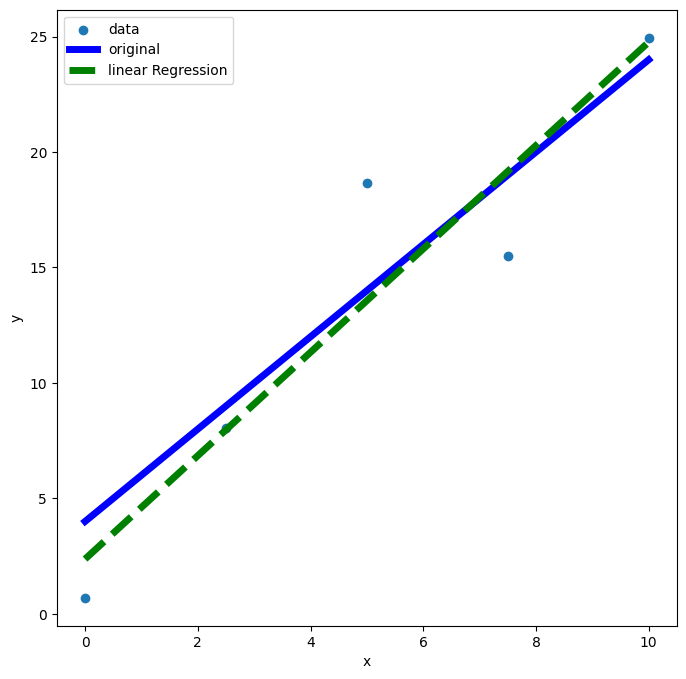

In [7]:
import scipy.optimize as opt

sol = opt.minimize(mse,[0,0],args=(x,yMeas))

print("a_Opt = ",sol.x[0])
print("b_Opt = ",sol.x[1])

yOpt = model(x,[sol.x[0],sol.x[1]])
plt.figure(figsize=(8,8))
plt.scatter(x,yMeas,label='data')
plt.plot(x,y,'b-',label='original',lw=5)
plt.plot(x,yOpt,'g--',label='linear Regression',lw=5)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

Right, onto Bayesian stuff! For that we need two things: Prior distribution for our parameters $\theta$ and the likelihood $p(y_{meas} | \theta)$

For the prior we can assume a uniform distribution, since we have no prior knowledge about the problem. Since a uniform distribution is constant, it does not affect the shape of the posterior distribution, so we can ignore it for now. For the likelihood we can choose a (multivariate) Gaussian distribution with a mean of $y$. This means the likelihood has a dimension of the amount of data points we have measured. We further assume independence in the measurements so that the $N$-dimensional likelihood becomes the product of $N$ one-dimensional Gaussian distributions with mean $y_{meas,i}$:

\begin{equation*}
p(y_{meas} | \theta) = \prod_i^N \frac{1}{\sqrt{2 \pi \sigma^2}} \text{exp}[- \frac{(y_{meas,i} - M(\theta,x_i))^2}{2\sigma^2}]
\end{equation*}

$\sigma$ is the standard deviation of the measurement error. It can be used as an additional updating variable, but for simplicity we assume it is known here.

Usually, the values in the likelihood get very small very fast (because of the multiplication of small numbers in the above example), so often the logarithm is used, which turns the whole thing into a summation:

\begin{equation*}
\log p(y_{meas} | \theta) = N \log [\frac{1}{\sqrt{2 \pi \sigma^2}}] - \sum_i^N \frac{(y_{meas,i} - M(\theta,x_i))^2}{2\sigma^2}
\end{equation*}

In this case the likelihood is directly related to the posterior. Recall the Bayesian theorem:

\begin{equation*}
p(\theta | y_{meas}) = \frac{p(y_{meas} | \theta) p(\theta)}{p(y_{meas})}
\end{equation*}

Since the prior distribution and the evidence (the denominator) are constants, we also know the posterior up to a constant. Important: This only works under the assumption that we don't evaluate the function outside of the support of the prior! So in the end, the posterior becomes:

\begin{equation*}
p(\theta | y_{meas}) = \frac{p(y_{meas} | \theta)}{C}
\end{equation*}

In [8]:
def logLikelihood(theta,x,data,sigma):

    modelOutput = model(x,theta)

    return data.size * np.log(1/(np.sqrt(2*np.pi*sigma**2))) - np.sum((data - modelOutput)**2/2/sigma**2)

And we can also plot the function

Text(0, 0.5, 'b')

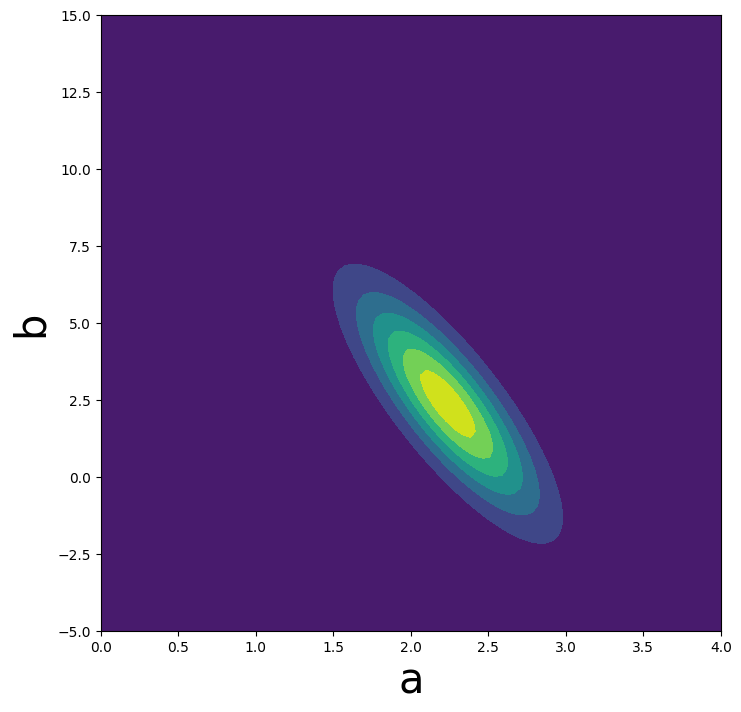

In [9]:
xlist = np.linspace(0, 4, 100)
ylist = np.linspace(-5, 15, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = np.zeros([100,100])

for i in range(100):
    for j in range(100):
        Z[j,i] = np.exp(logLikelihood([xlist[i],ylist[j]],x,yMeas,sigma))
        
fig=plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)
cp = ax.contourf(X, Y, Z)
plt.xlabel("a",fontsize=30)
plt.ylabel("b",fontsize=30)

Now, in principle, we are done, since we have a probability model for our parameter $\theta$ (save for some constants). But with more complicated models, we arrive at one of the main issues in model updating. Lets look at the (log-)likelihood function again:

\begin{equation*}
\log p(y_{meas} | \theta) = N \log [\frac{1}{\sqrt{2 \pi \sigma^2}}] - \sum_i^N \frac{(y_{meas,i} - M(\theta,x_i))^2}{2\sigma^2}
\end{equation*}

The likelihood is directly dependent on the model output. In the case of an analytical function is is not so much an issue since we can just put the expression in there and do some numerical integration (although this also becomes quite complicated very fast) to calculate quantities of interest, such as mean, variance and so on. Calculation of probabilities (especially the denominator in the Bayes' theorem) involves a lot of integration over the whole domain of the likelihood. If you now consider that $M(\theta,x)$ can also be more complicated model you can imagine that this is in most cases not possible at all.

This is why sampling methods are used to explore the PDF with Markov Chains. The basic idea is to start with some state $\theta_0$. From there, samples are drawn by use of Markov Chains, where each state of the chain depends only on its previous state. A very easy and basic algorithm is the Metropolis-Hastings algorithm. It works by introducing a proposal distribution $p_{prop}$ (different from the one that we are trying to evaluate), from which sampling is easy. For that we use here a Gaussian distribution with the identity matrix as covariance. Depending on the implementation, the proposal distribution is centered at the current state. A proposal sample is then drawn, the values of the PDF in question (the likelihood in this case) are compared and the proposed sample is only accepted with a probability proportional to the ratio between the function values of the current and the proposal sample. Theoretically, this leads to a chain of samples that are distributed according to the target distribution $p_{tar}$, which is exactly what we want.

The full algorithm:

- Set an initial sample $\theta_0$
- Set $i = 1$
- Sample a proposal sample $\theta_{prop}$ from the proposal distribution $p_{prop}(\theta | \theta_{i-1})$
- Calculate $\alpha = p_{tar}(\theta_{prop})\ /\ p_{tar}(\theta_{i-1})$
- Sample $u$ from $U(0,1)$
- Set $\theta_i = \theta_{prop}$ if $\alpha > u$
- Otherwise set $\theta_i = \theta_{i-1}$
- Set i += 1 and repeat from step 3 until enough samples are drawn


Let's do it in one dimension first. So we set $a = a_0$ and only look for the value of $b$. We start at $\theta_0 = 0$. This choice is arbitrary, but the closer we start at the posterior function, the more accurate this becomes. There are of course a lot of other ways to set up these Markov Chains, but the principle remains the same in most (if not all) these methods.

alpha = 16.432195457995864


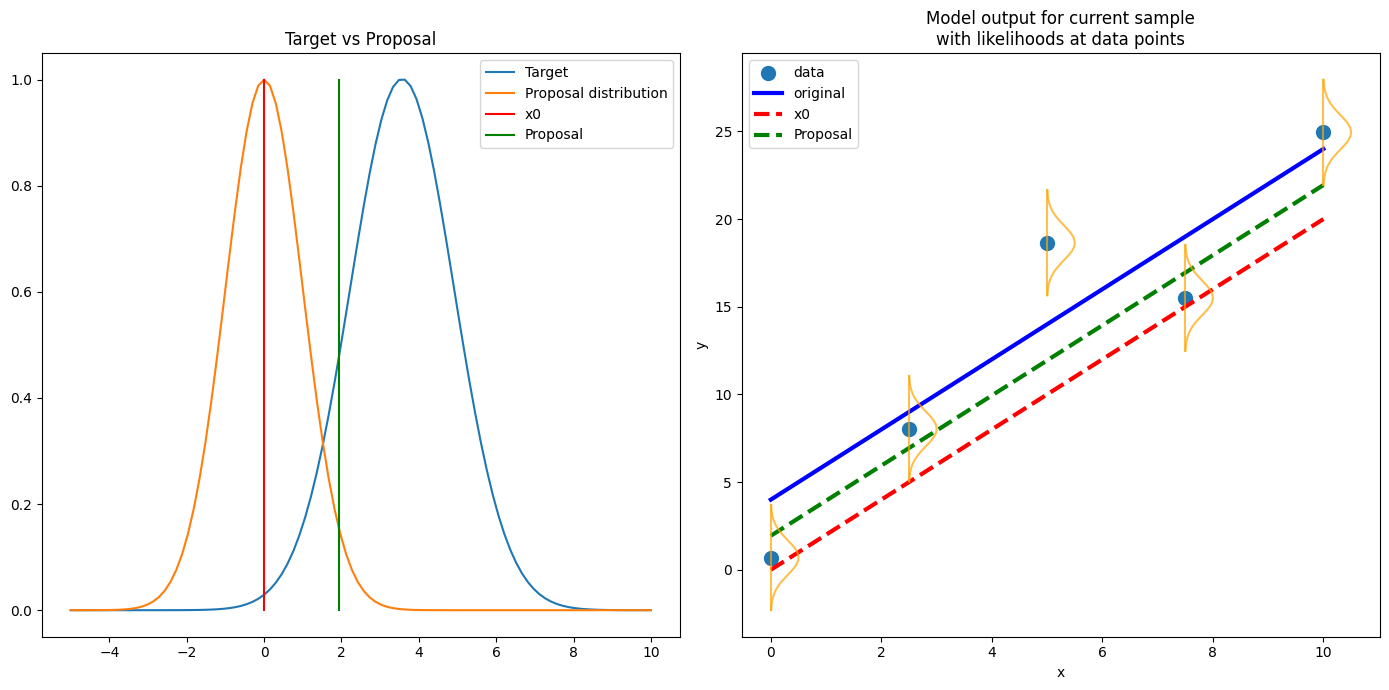

In [16]:
import scipy.stats as st

t0 = 0 # initial sample for the chain
C0 = 1 # unit covariance

tarFct = lambda theta: np.exp(logLikelihood([a0,theta],x,yMeas,sigma))

chain = np.array(t0)

tProp = np.random.normal(t0,C0)

alpha = tarFct(tProp) / tarFct(t0)

print("alpha =",alpha)

xlist = np.linspace(-5,10,100) # for plotting

tar = np.zeros(100)
prop = np.zeros(100)
for i in range(100):
    tar[i] = tarFct(xlist[i])
    prop[i] = st.norm.pdf(xlist[i],t0,C0)

plt.figure(figsize=(14,7))

# First subplot: Target and Proposal
plt.subplot(1,2,1)
plt.plot(xlist, tar/np.max(tar), label='Target')
plt.plot(xlist, prop/np.max(prop), label='Proposal distribution')
plt.plot([t0, t0], [0, 1], c='r', label='x0')
plt.plot([tProp, tProp], [0, 1], c='g', label='Proposal')
plt.legend()
plt.title("Target vs Proposal")

# Second subplot: Model output for current sample
plt.subplot(1,2,2)
plt.scatter(x, yMeas, label='data', s=100)
plt.plot(x, y, 'b-', label='original', lw=3)
plt.plot(x, model(x, [a0, t0]), 'r--', label='x0', lw=3)
plt.plot(x, model(x, [a0, tProp]), 'g--', label='Proposal', lw=3)

# Plot vertical likelihoods for each yMeas sample
for xi, yi in zip(x, yMeas):
    y_range = np.linspace(yi - 3*C0, yi + 3*C0, 100)
    likelihood = st.norm.pdf(y_range, loc=yi, scale=C0)
    # Normalize for better visualization
    likelihood = likelihood / np.max(likelihood) * 0.5
    plt.plot([xi]*len(y_range), y_range, color='orange', alpha=0.7)
    plt.plot(xi + likelihood, y_range, color='orange', alpha=0.7)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Model output for current sample\nwith likelihoods at data points")

plt.tight_layout()


Let's see if we accept the new sample!

In [460]:
U = np.random.rand()
if alpha > U:
    tNew = tProp
    print("Accepted!")
else:
    tNew = t0
    print("Not accepted!")
    
chain = np.append(chain,tNew)

Not accepted!


Nice. So we can now do this over and over again, keep the accepted samples and throw away the rejected ones.

You can run the code below again and again and see what is happening in the plot.

alpha =  55.0878026920532
U = 0.4358603278950667
accepted!


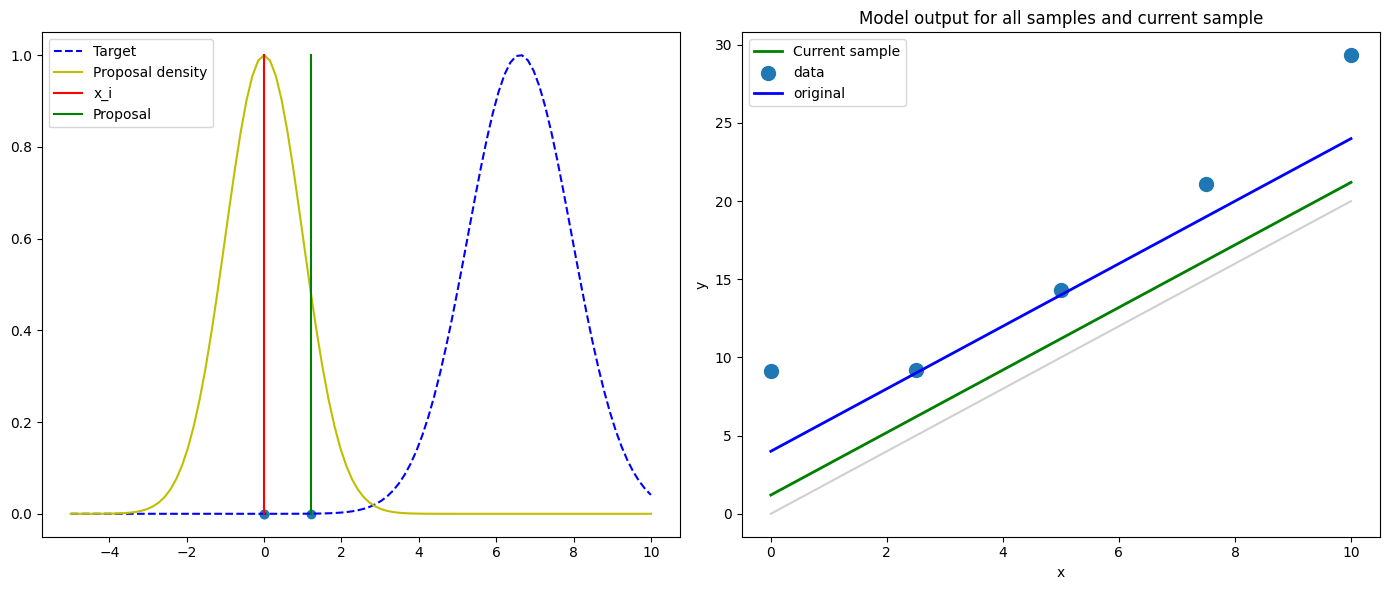

In [461]:
# xProp = np.random.multivariate_normal(x0,C0,1) # draw one sample from a multivariate normal distribution with mean x0 and covariance C0
tProp = np.random.normal(chain[-1],C0)

alpha = tarFct(tProp) / tarFct(chain[-1])

U = np.random.rand()

print("alpha = ",alpha)
print("U =",U)

if alpha > U:
    tNew = tProp # accept proposed sample as new sample
    print("accepted!")
else:
    tNew = chain[-1] # reject and use last sample as new sample
    print("rejected!")

chain = np.append(chain,tNew) # add xnew to chain

xlist = np.linspace(-5,10,100) # for plotting
plt.figure(figsize=(14, 6))

tar = np.zeros(100)
prop = np.zeros(100)
for i in range(100):
    tar[i] = tarFct(xlist[i])
    prop[i] = st.norm.pdf(xlist[i],chain[-2],C0)

# First subplot: Target and Proposal (already plotted above)
plt.subplot(1, 2, 1)
plt.plot(xlist, tar / np.max(tar), 'b--', label='Target')
plt.plot(xlist, prop / np.max(prop), 'y-', label='Proposal density')
plt.plot([chain[-2], chain[-2]], [0, 1], c='r', label='x_i')
plt.plot([tProp, tProp], [0, 1], c='g', label='Proposal')
plt.scatter(chain, np.zeros(len(chain)))
plt.legend()

# Second subplot: Model output for all samples in the chain and current sample
plt.subplot(1, 2, 2)
for t in chain:
    plt.plot(x, model(x, [a0, t]), color='gray', alpha=0.2)
plt.plot(x, model(x, [a0, chain[-1]]), 'g-', lw=2, label='Current sample')
plt.scatter(x, yMeas, label='data', s=100)
plt.plot(x, y, 'b-', label='original', lw=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Model output for all samples and current sample')
plt.tight_layout()
# tar = np.zeros(100)
# prop = np.zeros(100)
# for i in range(100):
#     tar[i] = tarFct(xlist[i])
#     prop[i] = st.norm.pdf(xlist[i],chain[-2],C0)

# fig = plt.figure(figsize=(7,7))
# plt.plot(xlist,tar/np.max(tar),'b--',label='Target')
# plt.plot(xlist,prop/np.max(prop),'y-',label='Proposal')
# plt.plot([chain[-2],chain[-2]],[0,1],c='r',label='x_i')
# plt.plot([tProp,tProp],[0,1],c='g',label='Proposal')
# plt.scatter(chain,np.zeros(len(chain)))
# plt.legend();


Let's do it times more and look at the histogram of the samples.

In [462]:
for i in range(10000):
    tProp = np.random.normal(chain[-1],C0/10)

    alpha = tarFct(tProp) / tarFct(chain[-1])

    U = np.random.rand()

    if alpha > U:
        tNew = tProp # accept proposed sample as new sample
    else:
        tNew = chain[-1] # reject and use last sample as new sample

    chain = np.append(chain,tNew)

Number of samples in chain = 10003
Mean of chain = 6.469868308964317
Variance of chain = 1.953917559985657


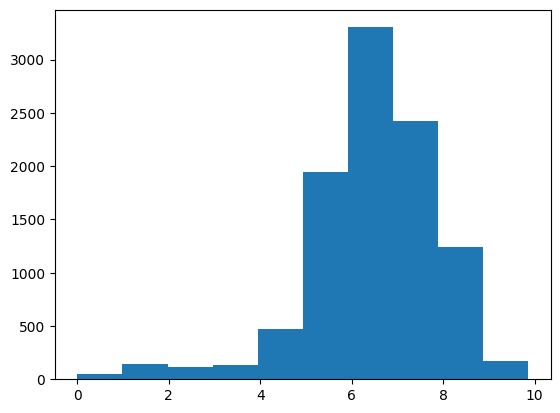

In [463]:
chainMean = np.mean(chain)
chainVar = np.var(chain)

plt.hist(chain)

print("Number of samples in chain =",chain.size)
print("Mean of chain =",chainMean)
print("Variance of chain =",chainVar)

Very nice. The mean should be somewhere around 4 (as 4 was the value for $b_0$), but we also get some more statistical information about possible values of $b$ dependent on our probability model. Now we can also look at the model output for various values of $b$, such as the average (which would hopefully give more or less the same result as the linear regression), but also upper and lower bounds, as well as things like the $1\, \sigma$ and $2\, \sigma$ intervals (Of course this is only valid under the assumption that $b$ is normally distributed).

Before we do that, we discard some of the samples from the chain, since it needed some time to converge to the true posterior density.

Chain size before burn-in:  10003
Chain size after burn-in:  9903
Number of samples in chain = 9903
Mean of chain = 6.525269355528126
Variance of chain = 1.666092445234226


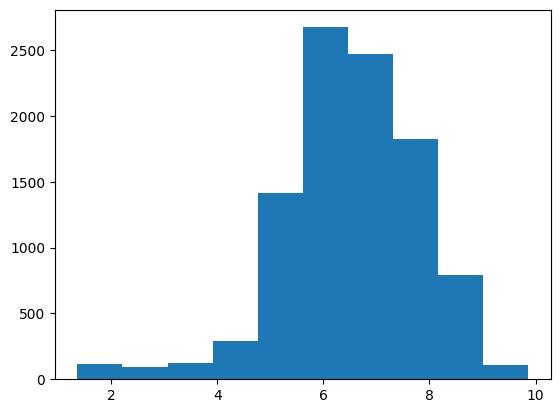

In [464]:
print("Chain size before burn-in: ",chain.size)
chain = chain[100:chain.size]
print("Chain size after burn-in: ",chain.size)

chainMean = np.mean(chain)
chainVar = np.var(chain)

plt.hist(chain)

print("Number of samples in chain =",chain.size)
print("Mean of chain =",chainMean)
print("Variance of chain =",chainVar)

Text(0, 0.5, 'y')

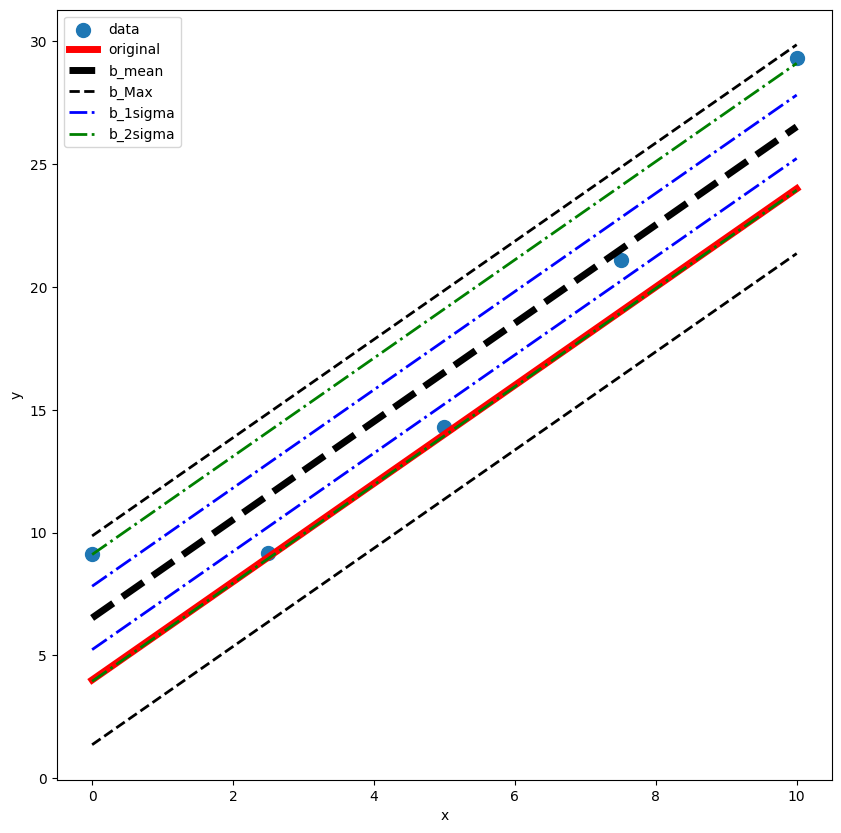

In [466]:
bMax = np.max(chain)
bMin = np.min(chain)
bMean = np.mean(chain)

bOneSigmaUp = bMean + np.std(chain)
bOneSigmaLow = bMean - np.std(chain)
bTwoSigmaUp = bMean + 2*np.std(chain)
bTwoSigmaLow = bMean - 2*np.std(chain)

plt.figure(figsize=(10,10))
plt.scatter(x,yMeas,label='data',s=100)
plt.plot(x,y,'r-',label='original',lw=5)
plt.plot(x,model(x,[a0,bMean]),'k--',label='b_mean',lw=5)
plt.plot(x,model(x,[a0,bMax]),'k--',label='b_Max',lw=2)
plt.plot(x,model(x,[a0,bMin]),'k--',lw=2)
plt.plot(x,model(x,[a0,bOneSigmaUp]),'b-.',label='b_1sigma',lw=2)
plt.plot(x,model(x,[a0,bOneSigmaLow]),'b-.',lw=2)
plt.plot(x,model(x,[a0,bTwoSigmaUp]),'g-.',label='b_2sigma',lw=2)
plt.plot(x,model(x,[a0,bTwoSigmaLow]),'g-.',lw=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

So by considering the regression problem in a stochastic setting, we can get more information about the data. The result includes more information than the optimization procedure.

We can also of course do it for $a$ and $b$. So let's write the MH-algorithm into a function and update $a$ and $b$ at the same time!

In [468]:
def mh(func,x0,C0,N):
    chain = np.array(x0)
    for i in range(1,N):
        if x0.shape[1]>1:
            xProp = np.random.multivariate_normal(chain[i-1,:],C0,1) # draw one sample from a multivariate normal distribution with mean x0 and covariance C0
        else:
            xProp = np.random.normal(chain[i-1,:],C0)

        alpha = func(xProp.flatten()) / func(chain[i-1,:].flatten())
        U = np.random.rand()
        if alpha > U:
            xNew = np.array(xProp) # accept proposed sample as new sample
        else:
            xNew = chain[i-1,:] # reject and use last sample as new sample
            xNew = np.expand_dims(xNew,0)
        chain = np.append(chain,xNew,0)
    return chain

Lets also do some nice charts with the histograms for $\theta_1$ and $\theta_2$ and a scatterplot with the original posterior. 

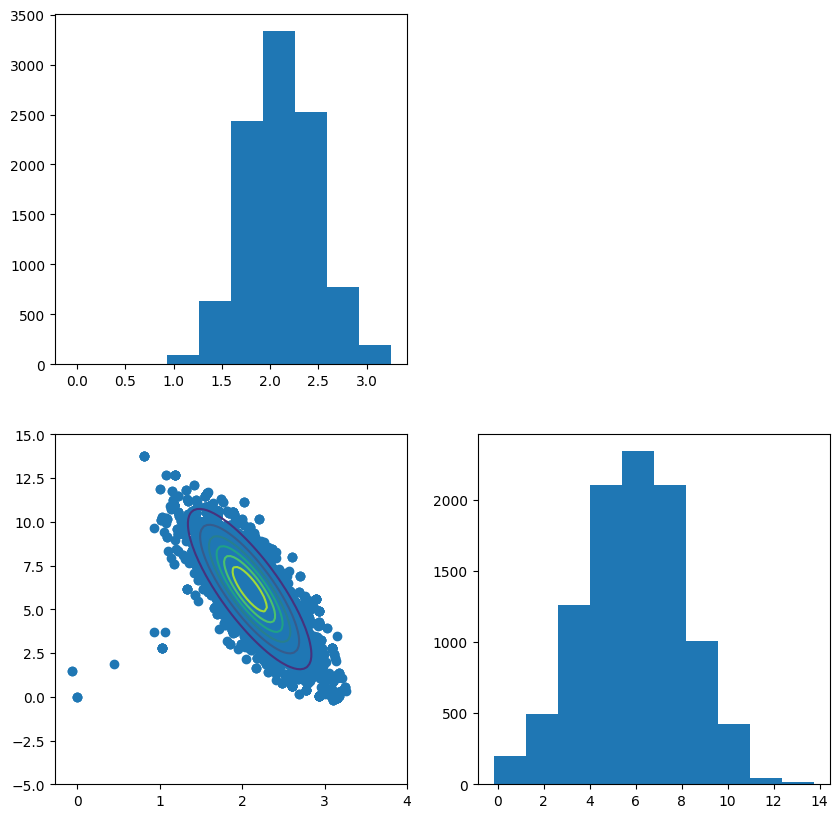

In [469]:
tarFct = lambda theta: np.exp(logLikelihood([theta[0],theta[1]],x,yMeas,sigma))

t0 = np.array([[0,0]])

chain = mh(tarFct,t0,np.eye(2),10000)

fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(chain[:,0])
plt.subplot(2,2,4)
plt.hist(chain[:,1])
sp = plt.subplot(2,2,3)
plt.scatter(chain[:,0],chain[:,1])
cp = sp.contour(X, Y, Z) # use plot from before


Discarding the burn-in...

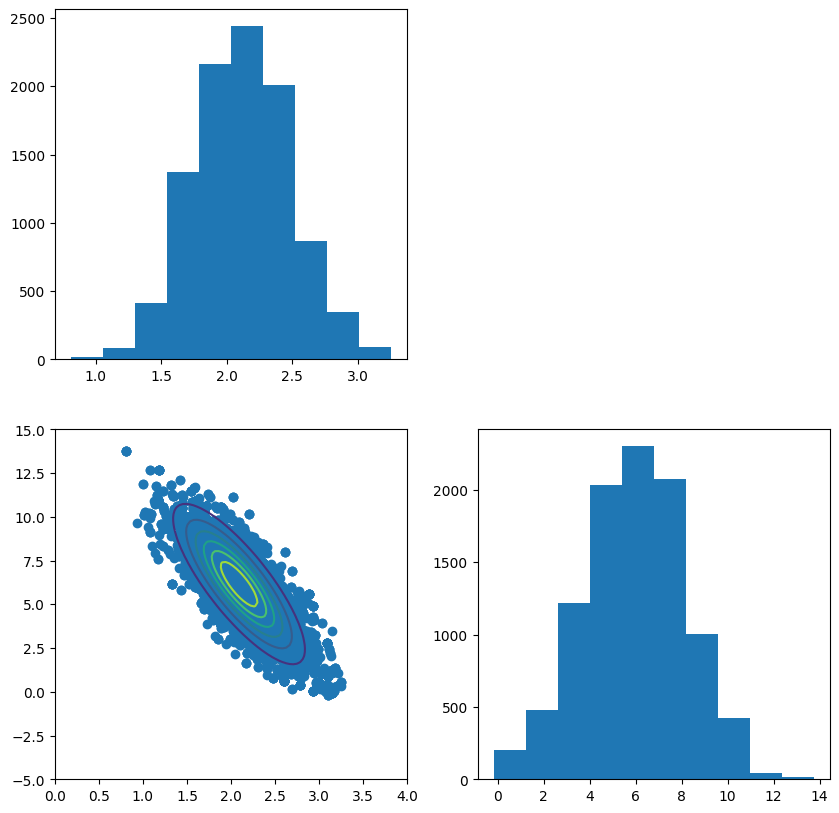

In [471]:
chain = chain[100:chain.shape[0],:]

fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(chain[:,0])
plt.subplot(2,2,4)
plt.hist(chain[:,1])
sp = plt.subplot(2,2,3)
plt.scatter(chain[:,0],chain[:,1])
cp = sp.contour(X, Y, Z) # use plot from before

And for the model output

a_mean = 2.117152850080892
b_mean = 5.941789346802247
a_Opt = 2.0913580351434238
b_Opt = 6.155057117176267


Text(0, 0.5, 'y')

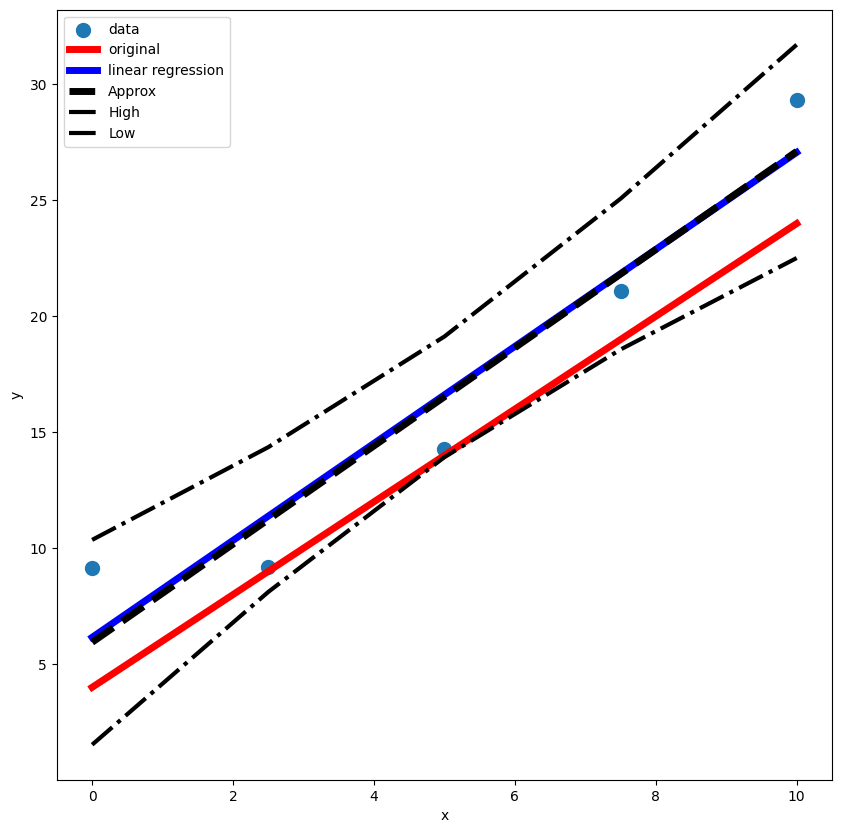

In [472]:
modOut = np.zeros([chain.shape[0],N])
modOutHigh = np.zeros(N)
modOutLow = np.zeros(N)

for i in range(chain.shape[0]):
    modOut[i,:] = model(x,[chain[i,0],chain[i,1]])

for i in range(N):
    modOutHigh[i] = np.mean(modOut[:,i]) + 2*np.std(modOut[:,i])
    modOutLow[i] = np.mean(modOut[:,i]) - 2*np.std(modOut[:,i])

print("a_mean =",np.mean(chain[:,0]))
print("b_mean =",np.mean(chain[:,1]))

print("a_Opt =",sol.x[0])
print("b_Opt =",sol.x[1])

plt.figure(figsize=(10,10))
plt.scatter(x,yMeas,label='data',s=100)
plt.plot(x,y,'r-',label='original',lw=5)
plt.plot(x,yOpt,'b-',label='linear regression',lw=5)
plt.plot(x,np.mean(modOut,0),'k--',label='Approx',lw=5)
plt.plot(x,modOutHigh,'k-.',label='High',lw=3)
plt.plot(x,modOutLow,'k-.',label='Low',lw=3)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
